In this weeks assignment you will work on variable selection and regularization of linear models, once again using the Auto-dataset. As before, you will try to predict mpg based on various predictors, but this time using substantially more models and a more advanced approach. There are two main learning goals:

    Gain practical experience with writing the code necessary for fitting and comparing a large(ish) number of models.
    Build intuition on overfitting, model evaluation, training and testing errors, and the impact of regularization (including variable selection).

Happy coding!

#### COMMENT: I used Claude Code especially for help and debugging in part 1 and 2.

In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress convergence warnings for λ=0

0. Preparation

Before any analyses we will prepare the dataset for the subsequent modelling.

    Load the Auto dataset into R or Python.
    Drop all variables except the (potential) predictors ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'] and the target variable 'mpg'.
    Split the dataset into a training set (80%) and a validation set (20%). It is probably a good idea to set a random seed and shuffle the dataset prior to this.
    Replace missing values (coded as '?') in the both datasets with the mean of the given variable in the training set.
    Standardize the predictors in the training set using z-score standardization.
    Standardize the predictors in validation set based on the means and standard deviations from the training set.
    Reflection: Discuss briefly why it is a good idea (or even necessary?) to standardize the variables before fitting the LASSO models in assignment 2. Why do we mean-fill and standardize the validation set based on information from the training set?

### 0. Preparation

In [3]:
# 1) Load the Auto dataset into Python
auto_df = pd.read_csv('Auto.csv')

# 2) Drop all variables except the (potential) predictors ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'] and the target variable 'mpg'.
cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'mpg']
auto_df = auto_df[cols]

# 3) Split the dataset into a training set (80%) and a validation set (20%). 
train_df, val_df = train_test_split(auto_df, test_size=0.2, random_state=42, shuffle=True)

# 4) Replace missing values (coded as '?') in both datasets with the mean of the given variable in the training set.
train_df = train_df.apply(pd.to_numeric, errors='coerce')
val_df = val_df.apply(pd.to_numeric, errors='coerce')

imputation_means = train_df.mean()
train_df = train_df.fillna(imputation_means)
val_df = val_df.fillna(imputation_means)

# 5) Standardize the predictors in the training set using z-score standardization.
predictors = cols[:-1] # not 'mpg'
std_means = train_df[predictors].mean()
std_stds = train_df[predictors].std()

train_df[predictors] = (train_df[predictors] - std_means) / std_stds

# 6) Standardize the predictors in validation set based on the means and standard deviations from the training set.
val_df[predictors] = (val_df[predictors] - std_means) / std_stds

print(f"Training set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")

train_df.head()

Training set: 317 rows
Validation set: 80 rows


,cylinders,displacement,horsepower,weight,acceleration,year,mpg
262,1.463258,1.056289,1.060041,0.527638,-0.832965,0.523049,19.2
113,0.291913,-0.389558,0.061587,-0.604995,-0.545642,-0.865616,21.0
176,0.291913,0.352644,-0.385089,0.273301,0.531820,-0.310150,19.0
63,1.463258,1.971991,1.848293,1.668590,-1.263950,-1.143349,14.0
245,-0.879433,-0.938979,-1.015691,-1.403661,-0.401981,0.523049,36.1


Reflection: Discuss briefly why it is a good idea (or even necessary?) to standardize the variables before fitting the LASSO models in assignment 2. Why do we mean-fill and standardize the validation set based on information from the training set?
   - It makes sense to standarize the variables so that we can compare variables (apples to apples, not apples to oranges), and its necessary because of LASSOs penalties of large scale features versus smaller scale features. Also, the mean-fill and standarization is based of the training set to prevent any data leakage.

### 1. Manual variable selection

In this assignment all models should be unregularized linear regression models fitted to predict mpg as a function of various subset of predictors. When we refer to the best model we mean the one achieveing the lowest mean squared error (MSE) in the validation set, if not otherwise specified.

    Find the optimal set of predictors of size [6, 5, 4, 3, 2, 1] based on model performance using backwards stepwise selection. Print out each set.
    Based on the models you have already trained, plot both training and validation MSE as a function of the number of predictors.
    Plot mpg predictions against actual mpg values for the validation set using the best model.
    Reflection: What is the best model based on training MSE? What about validation MSE? If they are different, reflect briefly on why. If not, could this happen? Why/why not?

Best 6 predictors: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
Best 5 predictors: ['cylinders', 'horsepower', 'weight', 'acceleration', 'year']
Best 4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
Best 3 predictors: ['weight', 'acceleration', 'year']
Best 2 predictors: ['weight', 'year']
Best 1 predictors: ['weight']


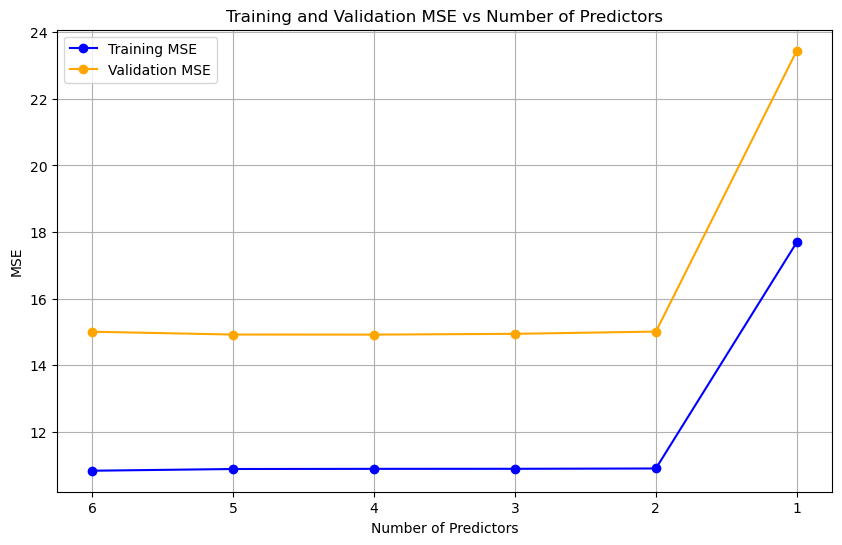

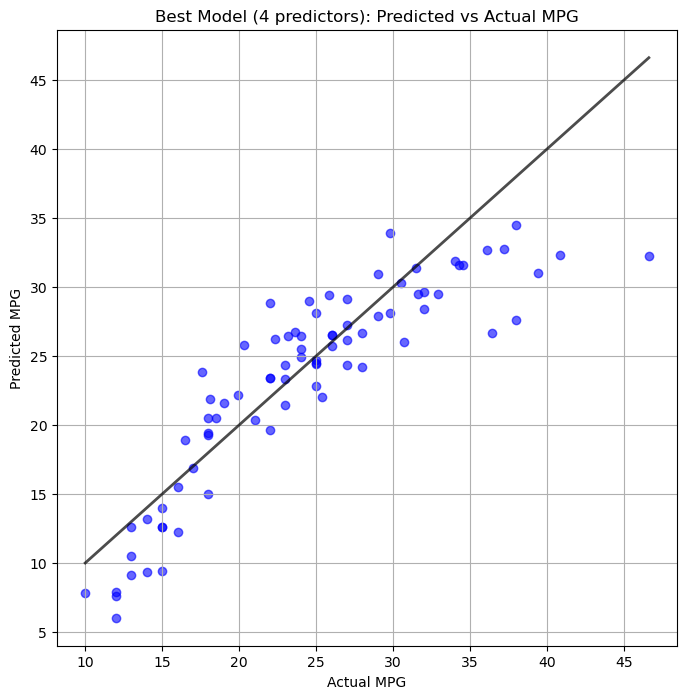


Best model uses 4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
Training MSE: 10.8924
Best validation MSE: 14.9216


In [4]:
# 1) Find the optimal set of predictors of size [6, 5, 4, 3, 2, 1] based on model performance using backwards stepwise selection.
best_models = {}
current_predictors = predictors.copy()

for n in [6, 5, 4, 3, 2, 1]:
    if n == 6:
        best_models[n] = current_predictors.copy()
    else:
        best_mse = float('inf')
        best_predictor_to_remove = None
        
        # Try removing each predictor and find which removal gives best validation MSE
        for p in current_predictors:
            temp_predictors = [x for x in current_predictors if x != p]
            lr = LinearRegression()
            lr.fit(train_df[temp_predictors], train_df['mpg'])
            mse = mean_squared_error(val_df['mpg'], lr.predict(val_df[temp_predictors]))
            
            if mse < best_mse:
                best_mse = mse
                best_predictor_to_remove = p
        
        # Remove the predictor that gave the best MSE
        current_predictors = [x for x in current_predictors if x != best_predictor_to_remove]
        best_models[n] = current_predictors.copy()
    
    print(f"Best {n} predictors: {best_models[n]}")

# 2) Based on the models you have already trained, plot both training and validation MSE as a function of the number of predictors.
train_mses = []
val_mses = []

for n in [6, 5, 4, 3, 2, 1]:
    lr = LinearRegression()
    lr.fit(train_df[best_models[n]], train_df['mpg'])
    train_mses.append(mean_squared_error(train_df['mpg'], lr.predict(train_df[best_models[n]])))
    val_mses.append(mean_squared_error(val_df['mpg'], lr.predict(val_df[best_models[n]])))

plt.figure(figsize=(10, 6))
plt.plot([6, 5, 4, 3, 2, 1], train_mses, 'o-', label='Training MSE', color='blue')
plt.plot([6, 5, 4, 3, 2, 1], val_mses, 'o-', label='Validation MSE', color='orange')
plt.xlabel('Number of Predictors')
plt.ylabel('MSE')
plt.title('Training and Validation MSE vs Number of Predictors')
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

# 3) Plot mpg predictions against actual mpg values for the validation set using the best model.
best_n = [6, 5, 4, 3, 2, 1][np.argmin(val_mses)]
lr_best = LinearRegression()
lr_best.fit(train_df[best_models[best_n]], train_df['mpg'])
val_pred = lr_best.predict(val_df[best_models[best_n]])

plt.figure(figsize=(8, 8))
plt.plot([val_df['mpg'].min(), val_df['mpg'].max()], 
         [val_df['mpg'].min(), val_df['mpg'].max()], 'k-', lw=2, alpha=0.7)
plt.scatter(val_df['mpg'], val_pred, alpha=0.6, color='blue')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title(f'Best Model ({best_n} predictors): Predicted vs Actual MPG')
plt.grid(True)
plt.show()

print(f"\nBest model uses {best_n} predictors: {best_models[best_n]}")
print(f"Training MSE: {train_mses[[6,5,4,3,2,1].index(best_n)]:.4f}")
print(f"Best validation MSE: {min(val_mses):.4f}")

Reflection: What is the best model based on training MSE? What about validation MSE? If they are different, reflect briefly on why. If not, could this happen? Why/why not?

Based on training MSE, the models with 2-6 predictors are all performing quite similar (MSE ≈ 10.89). Regarding the validation MSE, the best model uses 4 predictors (MSE = 14.92). They are different because adding more predictors (5 or 6) doesn't improve training MSE much, but seems to add noise rather than signal.

They MSE's are different since the training set is what the model sees and learns from, however, the validation set is 'unseen data' to our model. A difference between training and validation MSE is expected because the model was optimized specifically for the training data patterns. The slightly higher validation MSE indicates some overfitting - the model learned some noise from the training data that doesn't help with new data. A very large gap would mean severe overfitting, but our gap seems reasonable.

Theoretically they could be equal, if we had perfect regularization and the data splits happened to be identical, but in practice this rarely happens since the model is fit to minimize training error specifically.

### 2. Regularization and automatic variable selection

In this assignment you will fit regularized LASSO models to investigate how the regularization parameter affects predictive performance and degree of overfitting.

    Fit a range of LASSO models to predict mpg using all the predictors, with eleven lambdas uniformly spaced between 0 and 10 (e.g. 0, 1, 2, ..., 9, 10)
    Plot the train and validation MSE as a function of the value of lambda
    Using the values plotted in b), print the lambda yielding the best model based on training MSE and validation MSE, and their corresponding MSE values.
    Reflection: Is the best model based on training MSE and validation MSE using the same lambda? If not, why not? What would be the general pattern we expect to see here?
    Plot predictions against actual values and for the validation set using the best model.
    Reflection: Is the best LASSO model better or worse than the best model found using backward stepwise selection? Discuss briefly why this is/is not the case.
    Print the names and coefficients of the predictors that are used by the LASSO model (e.g. not set to 0). How does this compare to the list you found using backwards stepwise selection?

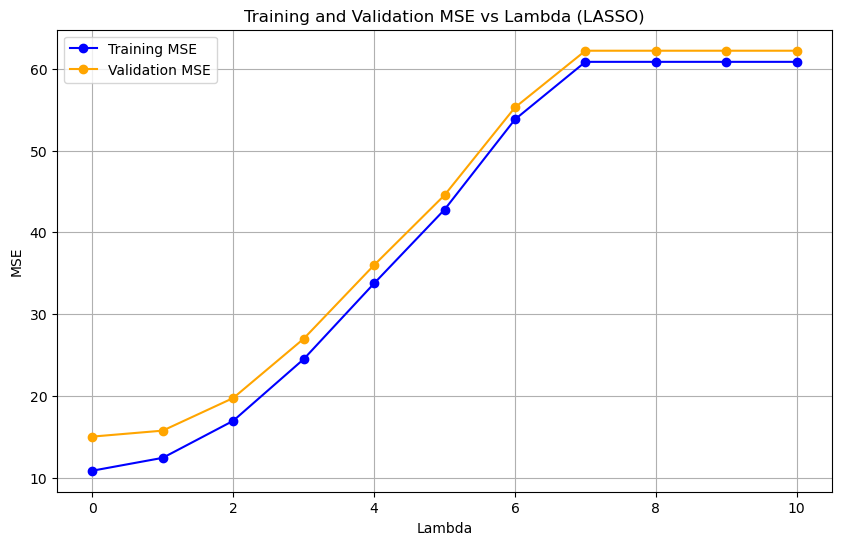

Best lambda based on training MSE: 0.0, MSE: 10.8360
Best lambda based on validation MSE: 0.0, MSE: 15.0084


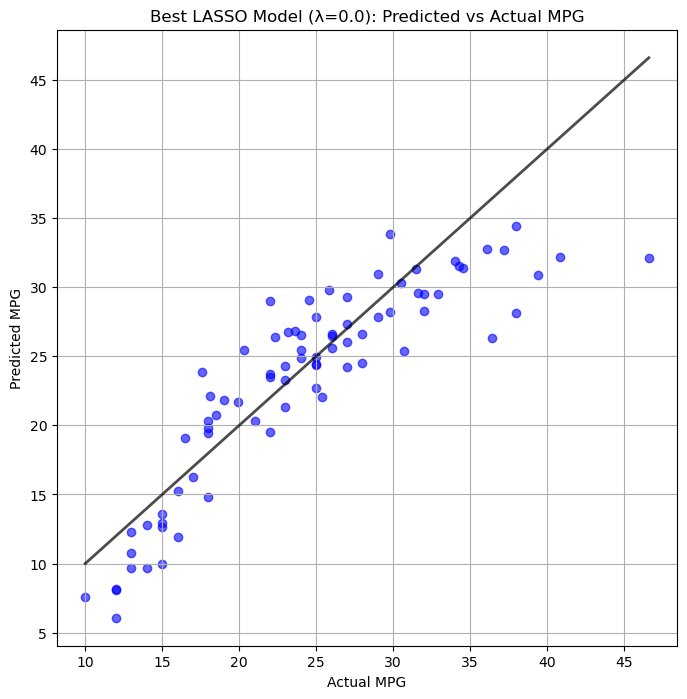


Predictors used by best LASSO model (λ=0.0):
  cylinders: -0.6806
  displacement: 0.9969
  horsepower: -0.0306
  weight: -5.8954
  acceleration: 0.1590
  year: 2.7689
Best LASSO MSE: 15.0084


In [ ]:
# 1) Fit a range of LASSO models to predict mpg using all the predictors, with eleven lambdas uniformly spaced between 0 and 10 (e.g. 0, 1, 2, ..., 9, 10)
lambdas = np.linspace(0, 10, 11)
lasso_train_mses = []
lasso_val_mses = []
lasso_models = []

for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(train_df[predictors], train_df['mpg'])
    lasso_models.append(lasso)
    
    lasso_train_mses.append(mean_squared_error(train_df['mpg'], lasso.predict(train_df[predictors])))
    lasso_val_mses.append(mean_squared_error(val_df['mpg'], lasso.predict(val_df[predictors])))

# 2) Plot the train and validation MSE as a function of the value of lambda
plt.figure(figsize=(10, 6))
plt.plot(lambdas, lasso_train_mses, 'o-', label='Training MSE', color='blue')
plt.plot(lambdas, lasso_val_mses, 'o-', label='Validation MSE', color='orange')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('Training and Validation MSE vs Lambda (LASSO)')
plt.legend()
plt.grid(True)
plt.show()

# 3) Using the values plotted in b), print the lambda yielding the best model based on training MSE and validation MSE, and their corresponding MSE values.
best_train_idx = np.argmin(lasso_train_mses)
best_val_idx = np.argmin(lasso_val_mses)

print(f"Best lambda based on training MSE: {lambdas[best_train_idx]:.1f}, MSE: {lasso_train_mses[best_train_idx]:.4f}")
print(f"Best lambda based on validation MSE: {lambdas[best_val_idx]:.1f}, MSE: {lasso_val_mses[best_val_idx]:.4f}")

# 5) Plot predictions against actual values and for the validation set using the best model.
best_lasso = lasso_models[best_val_idx]
val_pred_lasso = best_lasso.predict(val_df[predictors])

plt.figure(figsize=(8, 8))
plt.plot([val_df['mpg'].min(), val_df['mpg'].max()], 
         [val_df['mpg'].min(), val_df['mpg'].max()], 'k-', lw=2, alpha=0.7)
plt.scatter(val_df['mpg'], val_pred_lasso, alpha=0.6, color='blue')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title(f'Best LASSO Model (λ={lambdas[best_val_idx]:.1f}): Predicted vs Actual MPG')
plt.grid(True)
plt.show()

# 7) Print the names and coefficients of the predictors that are used by the LASSO model (e.g. not set to 0).
print(f"\nPredictors used by best LASSO model (λ={lambdas[best_val_idx]:.1f}):")
for pred, coef in zip(predictors, best_lasso.coef_):
    if abs(coef) > 1e-10:
        print(f"  {pred}: {coef:.4f}")

print(f"Best LASSO MSE: {lasso_val_mses[best_val_idx]:.4f}")

Reflection: Is the best model based on training MSE and validation MSE using the same lambda? If not, why not? What would be the general pattern we expect to see here?
- Both training and validation MSE achieve their best at λ=0. This is uncommon - usually validation MSE improves with some regularization while training MSE prefers no regularization. We would expect training MSE to increase monotonically with λ, and validation MSE to show a U-shape with minimum at λ>0. In this case, the data might not benefit from L1 regularization.

Reflection: Is the best LASSO model better or worse than the best model found using backward stepwise selection? Discuss briefly why this is/is not the case.
- LASSO performs worse (MSE=15.0084) than backward selection (MSE=14.9216). This happens because at λ=0, LASSO becomes unregularized regression keeping all 6 predictors. Backward selection performed better by completely removing cylinders and displacement, finding that 4 predictors was optimal. The full removal approach worked better in this case than keeping all variables.

Print the names and coefficients of the predictors that are used by the LASSO model (e.g. not set to 0). How does this compare to the list you found using backwards stepwise selection?

- Predictors used by best LASSO model (λ=0.0):
  cylinders: -0.6806
  displacement: 0.9969
  horsepower: -0.0306
  weight: -5.8954
  acceleration: 0.1590
  year: 2.7689
- Best LASSO MSE: 15.0084

- Backward selection used 4 predictors: ['horsepower', 'weight', 'acceleration', 'year']
- Best backward selection MSE: 14.9216

- Lasso kept all six predictors, while backward selection only used four.